Setup conda env and import packages

In [1]:
# # create conda env
# # in it, install: 
# conda install "numpy<2.0" "scipy<1.12"
# conda install matplotlib
# conda install tqdm
# conda install numba
# pip install triangle
# conda instal ffmpeg
# import matplotlib=3.5
# print(matplotlib.__version__)
import numpy as np
import sys
import os
sys.path.append(os.path.abspath('..'))
import synmorph as sm

Setup parameters of model 
- L: length of simulation in # of cells
- A0: target cell area
- P0: target cell shape index (P/sqrt(A)) 
- kappa_A: Coefficient for deviation from target area in energy functional
- kappa_P: Coefficient for deviation from target perimeter in energy functional
- W: interaction matrix encoding relative interfacial tensions
- a: maximal radius to engage in repulsion
- k: coefficient of repulsion

energy function is currently:  E = Sum_i (kappa_A/2) * (Ai - A0)^2 + (kappa_P/2) * (Pi - P0)^2 + Sum_j J_ij*lij

In [2]:
# ---- set basic params ---- 
tissue_radius = 4 # radius of tissue in # cells
N_t = 20000 # final time
dt = 0.025 
tskip = 10      # num timesteps between saved timepoints
exp_dir = 'test2'       # make a function of key parameters to save them in title
num_frames = int(N_t / 40)        # num frames for animation
video_file_name = f'Nt={N_t}'  # name of video file
simulate = True        # whether to run simulation

ctype_proportions = (0.5,0.5)       # proportions of LEP and MEP, respectively


# ---- motility params ---- 
Dr = 0.05        # cell persistence; 0.1
v0 = [0.05, 0.1, 0.001]   # magnitude of cell motility

# ---- set relative magnitudes of tensions (Y) and interaction matrix (W)---- 
gamma_scale = 0.12   # scaling factor for tensions
Y = np.array([-0.1, -0.1, -0.04, -0.2, -0.3]) * gamma_scale    # 'LL', 'LM', 'LX', 'MM', 'MX' interfacial tensions
ECM_ECM = -0.3       # ECM-ECM interfacial tension

# ---- interaction matrix ----
W = (np.array([[Y[0], Y[1], Y[2]], \
                [Y[1], Y[3], Y[4]], \
                [Y[2], Y[4], ECM_ECM]]))

# ---- setup tissue parameters ----
tissue_params = {"L": 14,               
                 "A0": 1,
                 "P0": 3.82, #3.81,
                 "kappa_A": 1,
                 "kappa_P": 0.1,
                 "W": W, #np.array(((0, 0.0762), (0.0762, 0)))*0.75,
                 "a": 0.2, #0,
                 "k": 2} # 0}

# ---- init configuration ----
init_params = {
    "init_noise": 0.01, #0.005,
    "c_type_proportions": (0,0,0),  # vestigial
    "init_mode": "ball_by_radius",            # <— NEW
    "ball_radius": tissue_radius,                       # choose your radius in domain units
    "ball_non_ecm_types": (0, 1),     # types inside ball 0: LEP, 1: MEP
    "ball_non_ecm_proportions": ctype_proportions,  # <-- use this for 80/20 split
}

# ---- motility parameters ----
active_params = {
    "Dr": Dr,
    "v0": v0
}


simulation_params = {"dt": dt,  # width of timestep
                     "tfin": N_t,  # final time
                     "tskip": tskip,  # num timesteps between saved timepoints
                     "grn_sim": None}

save_options = {"save": "last",
                "result_dir": "./results",
                "name": video_file_name,
                "compressed": True}

run_options = {"equiangulate": True,
               "equi_nkill": 3}

sim = sm.simulation(tissue_params=tissue_params,
                    active_params=active_params,
                    init_params=init_params,
                    simulation_params=simulation_params,
                    run_options=run_options,
                    save_options=save_options)

if simulate:
    sim.simulate(progress_bar=True)



>>> get_l_interface() completed <<<



Simulation progress:   0%|                                               | 0/800000 [00:00<?, ?it/s]

phi_save[0] = [0. 0. 0.]


Simulation progress:  11%|███▊                              | 89039/800000 [03:51<30:51, 383.95it/s]


KeyboardInterrupt: 

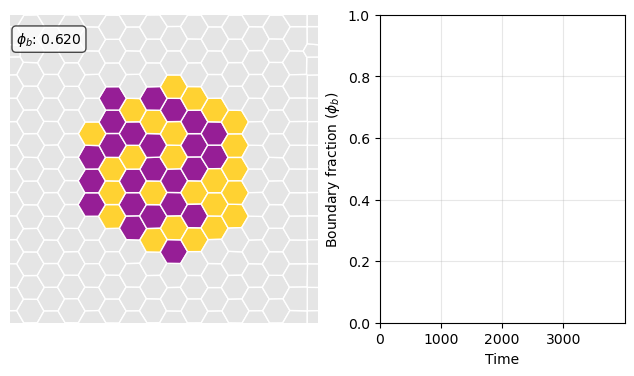

In [7]:
sim.animate_c_types(n_frames=num_frames,
                    c_type_col_map=["#FFD232", "#961E96", "#E5E5E5"],
                    file_name=video_file_name, dir_name="./SPV_simulations")

In [8]:
sim.save(video_file_name, id=sim.id, 
         dir_path="./results", 
         compressed=save_options["compressed"])

In [9]:
import bz2, pickle
simulation_file_name = video_file_name

with bz2.BZ2File("./results/" + simulation_file_name + "_simulation.pbz2", "rb") as f:
    data = pickle.load(f) 

print(data.keys())

dict_keys(['simulation_params', 'save_options', 't', 't_span', 't_span_save', 'nt', 'nts', 'x_save', 'tri_save', 'var_save', 'grn', 'phi_save', 'date', 'name', 'id', 'save_dir', 'save_dir_pickled', 'save_dir_plots'])


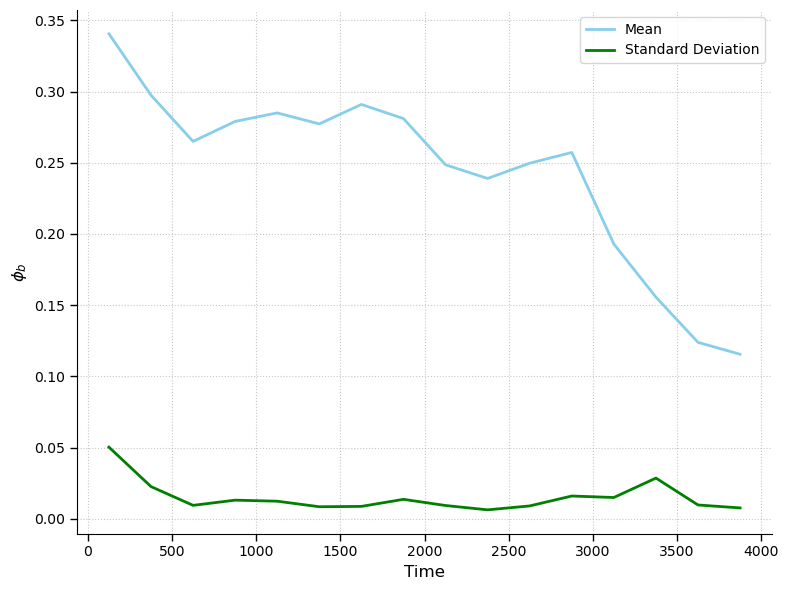

In [10]:
from data_analytics import binned_stats

binned_stats(data, bin_size=250)